<a href="https://colab.research.google.com/github/ankramirez/Data_Science/blob/main/movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project - Recommendation Systems: Movie Recommendation System**

---------------
## **Context**
---------------

Online streaming platforms like **Netflix** have plenty of movies in their repository and if we can build a **Recommendation System** to recommend **relevant movies** to users, based on their **historical interactions**, this would **improve customer satisfaction** and hence, it will also improve the revenue of the platform. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system.

-----------------
## **Objective**
-----------------

In this project we will be building various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

we are going to use the **ratings** dataset. 

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this case study.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [4]:
# Import the dataset
rating = pd.read_csv('ratings.csv') 

Let's check the **info** of the data

In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [6]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

## Exploring the dataset

Let's explore the dataset and answer some basic data-related questions:


###**Printing the top 5 rows of the dataset**

In [7]:
# Printing the top 5 rows of the dataset Hint: use .head()

rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### Distribution of ratings


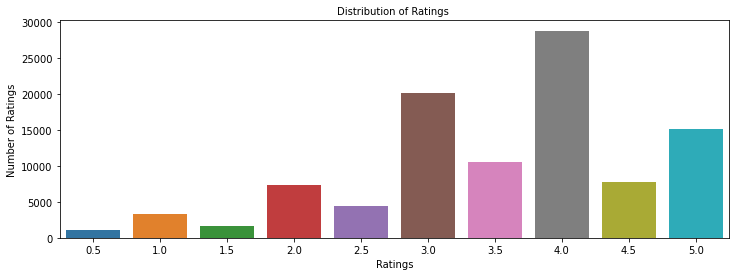

In [8]:
plt.figure(figsize = (12, 4))

sns.countplot(x='rating',data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [9]:
#printing the values of each rating
rating['rating'].value_counts()

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

In [10]:
rating.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100004.0,347.011310,195.163838,1.0,182.0,367.0,520.0,671.0
movieId,100004.0,12548.664363,26369.198969,1.0,1028.0,2406.5,5418.0,163949.0
rating,100004.0,3.543608,1.058064,0.5,3.0,4.0,4.0,5.0


- The distribution of ratings goes from 0.5 to 5.0, with a step of 0.5.
- The most frequent rating is 4.0, around 30k counts, the second most frequent rating is 3.0, with a count of around 20k. 
-The mean seams to be somewhere around 3.0 and 4.0, which is later confirmed by the description of the data (with a value of 3.54).
- The distribution is skewed right, which can also be infered by looking at the median and Q3, which has the same value.

### What is the total number of unique users and unique movies?


In [11]:
# Finding number of unique users

rating['userId'].nunique()

671

In [12]:
# Finding number of unique movies


rating['movieId'].nunique()

9066

### Is there any movie that has been interacted with more than once by the same user?

In [13]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [14]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

In [15]:
rating.shape

(100004, 3)

By grouping the dataset by the userId, and movieId, we get a Data Frame with the userId as the index and then, in the second column, different rows for all the movies to which the user assigned a rating.<br>
By counting all the rows of ratings (that are grouped by user and movieId, two values in rating for the same movie by the same user would be grouped in the same row) we obtain a total of 100004, which is the same as the total number of rows of the initial data; meaning that there are not two ratings assigned by a user to the same movie.

### Which is the most interacted movie in the dataset?

In [16]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

The most interacted movie is the movie with ID: 356, with a total of 341 ratings.

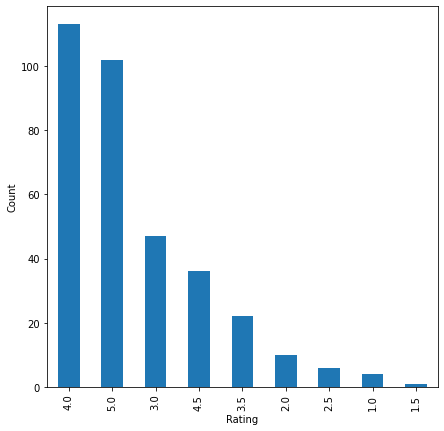

In [17]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

In [18]:
rating[rating['movieId'] == 356]['rating'].describe().T

count    341.000000
mean       4.054252
std        0.871521
min        1.000000
25%        3.500000
50%        4.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64

- From the plot of the ratings received by the movie 356, it can be observed that the most frequent rating is 4.0, closely followed by 5.0, which amounts more than 200 of the total number of ratings, therefore both the median and the mean should sit somewhere around this values (confirmed by the data description).
- If represented in an histogram plot, the distribution would be right-skewed, i.e. biased for values around 4 and 5.

### Which user interacted the most with any movie in the dataset?

In [19]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

The user who has interacted the most, by assigning the ratings to the movies, is the user 547, with a total of 2391 ratings. From the previous analysis, we know that all this interactions correspond to different movies, therefore there is still a total of 9066-2391= 6675 movies with which the user hasn't interacted.

### What is the distribution of the user-movie interactions in this dataset?

In [20]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

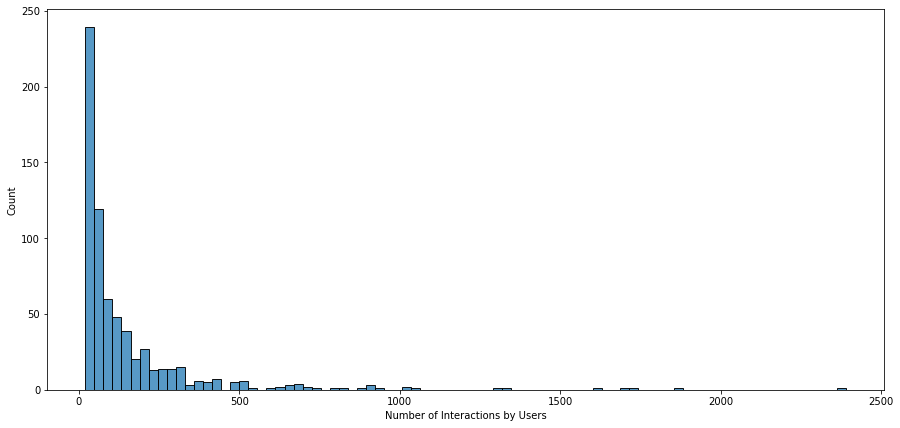

In [21]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

- From the plot it can be seen that there is a great number of users that has a low number of interactions.
- There is a scarse number of users that have interacted more than 1500 times, probably outliers.

## Creating Rank-Based Recommendation System

### **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [22]:
# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [23]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [24]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [25]:
list(top_n_movies(final_rating,5,50))

[858, 318, 913, 1221, 50]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [26]:
list(top_n_movies(final_rating,5))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [27]:
list(top_n_movies(final_rating,5,200))

[318, 50, 527, 608, 296]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

## **Model 2: User based Collaborative Filtering Recommendation System**

![collaborative_filtering.PNG](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/collaborative_filtering.PNG)

In the above **interactions matrix**, out of users B and C, which user is most likely to interact with the movie, "The Terminal"?

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

#### **Building Similarity/Neighborhood based Collaborative Filtering**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/cosine.PNG)

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`**. Finally splitting the data into train and test set.

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [28]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [29]:
# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options={'name': 'cosine','user_based':True},verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### RMSE for baseline user based collaborative filtering recommendation system

The RMSE obtained is 0.9925 for the collaborative filtering baseline model based on user-user similarity .

### What is the Predicted  rating for an user with userId=4 and for movieId=10 and movieId=3?**

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [30]:
groupeduserrating = rating.groupby(['userId', 'movieId','rating']).count()
print('Ratings of user 4')
groupeduserrating.loc[4].T

Ratings of user 4


movieId,10,34,112,141,153,173,185,260,289,296,...,3104,3108,3169,3208,3210,3251,3255,3263,3265,4006
rating,4.0,5.0,5.0,5.0,4.0,3.0,3.0,5.0,4.0,5.0,...,4.0,5.0,4.0,2.0,4.0,5.0,4.0,3.0,5.0,2.0


In [31]:
#r_ui=4 which is the true value of the rating for this user-movie pair
algo_knn_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

The actual rating value of the user for this movie is 4, while the estimated rating is 3.62, obtained with the user similarity based baseline model, difference of -0.38.


Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [32]:
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

The estimated rating for the user 4 and the movie 3 is 3.20, obtained with the user similarity based baseline model.

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

### Performing hyperparameter tuning for the baseline user based collaborative filtering recommendation system and finding the RMSE for tuned user based collaborative filtering recommendation system

In [33]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9638700989500326
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [34]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.970114,0.959826,0.961670,0.963870,0.004479,1,0.745086,0.737336,0.741314,0.741245,0.003164,1,0.345120,0.101951,6.013222,0.416855,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.998437,0.989204,0.989887,0.992509,0.004201,12,0.770635,0.764264,0.767199,0.767366,0.002604,12,1.182478,0.187772,5.371022,1.749212,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.974336,0.964519,0.967610,0.968822,0.004099,4,0.747892,0.740900,0.745964,0.744919,0.002948,3,0.210369,0.108736,3.193003,0.096610,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,1.001369,0.992584,0.994226,0.996060,0.003814,15,0.772106,0.766755,0.770715,0.769859,0.002267,15,0.804699,0.103278,3.214249,0.123538,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.981499,0.970472,0.972201,0.974724,0.004842,7,0.753843,0.745633,0.750114,0.749863,0.003356,6,0.177990,0.040497,3.203271,0.075184,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, the **final model by using tuned values of the hyperparameters** is built by using **grid search cross-validation**.



In [35]:
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options={'name':'msd','user_based':True},k=20,min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9571


0.9571445417153293

The RMSE for tuned user based collaborative filtering has a value of 0.9571, using the tuned parameters: msd, k: 20, min_k:3.

### What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering?

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [36]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

The predicted value for the tuned user based collaborative filtering model for user-movie pair 4-10 is: 3.74, which is closer to the real value of 4, and it's also a better stimation than that one made before the parameter tuning, difference of -0.26.

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [37]:
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

The predicted value for the tuned user based collaborative filtering model for user-movie pair 4-3 is: 3.20, the same value as the one obtained previous to the parameter tuning.


### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [38]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[665, 417, 647, 654, 260]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [39]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [40]:
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

### Predicting the top 5 movies for userId=4 with similarity based recommendation system

In [41]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

The top 5 movies recommended for the user 4 are:
- 309
- 3038
- 6273
- 98491
- 2721


## **Model 3: Item based Collaborative Filtering Recommendation System**

In [42]:
# Definfing similarity measure
sim_options = {'name':'msd',
               'user_based':False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9433


0.9433248796999978

### RMSE for baseline item based collaborative filtering recommendation system

The RMSE for the algorithm obtained using the item-item based collaborative filter is 0.9433, which is a lower value than the first approach with the user-user collaborative filter, and is also lower than that obtained after the fine-tuning of the user-user collaborative filter.


Let's us now predict rating for an user with `userId=4` and for `movieId=10`

### What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3?

In [43]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

The predicted value for the user-movie pair 4-10 with the item-item based collaborative filter is 4.26, which is an overestimation of the actual value which is 4. The difference is of 0.26.


Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [44]:
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

The predicted value for the user-movie pair 4-3 with the item-based collaborative filter is 3.87, which is greater than that predicted used user-based collaborative filter.


### Performing hyperparameter tuning for the baseline item based collaborative filtering recommendation system and finding the RMSE for tuned item based collaborative filtering recommendation system

In [45]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k':[20,30,40],'min_k': [3,6,9],
              'sim_options':{'name':['msd','cosine'],
                              'user_based':[False]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9396345324230655
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [46]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.951121,0.949471,0.950785,0.950459,0.000712,7,0.735424,0.732251,0.734215,0.733963,0.001307,7,10.439125,1.791919,12.447954,2.039394,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.012553,1.009549,1.012335,1.011479,0.001368,16,0.790155,0.786986,0.790846,0.789329,0.001680,16,22.817540,1.417047,10.810792,0.123290,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.951225,0.949263,0.951231,0.950573,0.000926,8,0.735592,0.732251,0.734537,0.734127,0.001395,8,7.172155,0.500171,13.125987,0.689631,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.012627,1.009545,1.012968,1.011713,0.001540,17,0.790363,0.787093,0.791241,0.789565,0.001785,17,20.022760,0.923818,11.676379,0.570804,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.951912,0.949183,0.953160,0.951419,0.001661,9,0.736129,0.732319,0.735819,0.734756,0.001728,9,7.189393,0.806548,11.303969,0.171927,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [47]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name':'msd','user_based':False}, k=40, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9433


0.9433184999641279

The RMSE of the model using item-based collaborative filter has gone down after applying hyperparameter tuning, however, not by much. New value: 0.9352

### What is the Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering?

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [48]:
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

After performing the hyper-parameter tuning for the item-collaborative filter based algorithm, the predicted value rhas increased: 4.43, difference: 0.43. (Worst than previously)

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [49]:
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

The value predicted for the user-movie pair after performing hyperparameter tuning has also increased from 3.87 to 4.0.

### **Identifying similar users to a given user (nearest neighbors)**
We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [50]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[77, 85, 115, 119, 127]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [51]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

### Predicting the top 5 movies for userId = 4 with similarity based recommendation system

In [52]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

**Write your Answer here:**<br>
The top 5 movies recommended for the user 4 (using the item-based collaborative filter) are:
- 84
- 1040
- 2481
- 3515
- 4521

It's worthy to remark that all the recommendations vary from those predicted using the user-based collaborative filter.


## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data. For example:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

Now if we notice the above movies closely:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF4.PNG)

Here **Action**, **Romance**, **Suspense** and **Comedy** are latent features of the corresponding movies. Similarly, we can compute the latent features for users as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF5.PNG)



### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

First we need to convert the below movie-rating dataset:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

into an user-item matrix as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF6.PNG)

We have already done this above while computing cosine similarities.

**SVD decomposes this above matrix into three separate matrices:**
- U matrix
- Sigma matrix
- V transpose matrix

#### **U-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF7.PNG)

the above matrix is a n x k matrix, where:
- n is number of users
- k is number of latent features

#### **Sigma-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF8.PNG)

the above matrix is a k x k matrix, where:
- k is number of latent features
- Each diagonal entry is the singular value of the original interaction matrix

#### **V-transpose matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF9.PNG)

the above matrix is a kxn matrix, where:
- k is the number of latent features
- n is the number of items

### **Build a baseline matrix factorization recommendation system**

In [53]:
# Using SVD matrix factorization
algo_svd = SVD(random_state=1)

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9054


0.9054387709175701

### RMSE for baseline SVD based collaborative filtering recommendation system

**Write your Answer here:**<br>
The RMSE value obtained using a baseline Matrix Factorization recommendation system has a value of 0.9054, which is so far, the lower than all the models used before.

### What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3?

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [54]:
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.91   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9077426421450028, details={'was_impossible': False})

The prediction for the user-item pair 4-10 is 3.91 for the baseline Matrix Factorization recommendation system, with a difference of 0.09 from the real value, and is the closest value obtained so far.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [55]:
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.78   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.783481116986586, details={'was_impossible': False})

The prediction obtained for the user-item pair 4-3 is 3.78 for the baseline Matrix Factorization recommendation system, which is moreorless halfway in the middle of the values previously obtained with the other models, being 3.20 and 3.87.


### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

### Performing hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and finding the RMSE for tuned SVD based collaborative filtering recommendation system?

In [56]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8946618872022719
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [57]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.945441,0.943587,0.939891,0.942973,0.002307,25,0.740783,0.737496,0.735665,0.737981,0.002117,25,5.038641,0.325393,0.602892,0.102091,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.949696,0.948182,0.945431,0.947770,0.001765,26,0.745484,0.742976,0.741806,0.743422,0.001534,26,4.922307,0.089715,0.563783,0.040322,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.955332,0.953055,0.950622,0.953003,0.001923,27,0.751458,0.748367,0.747633,0.749153,0.001658,27,5.160724,0.099402,0.643864,0.046139,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.907801,0.908310,0.905255,0.907122,0.001336,10,0.704321,0.701373,0.702283,0.702659,0.001232,9,4.894788,0.036870,0.594715,0.055171,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.914672,0.915189,0.912362,0.914074,0.001229,15,0.712041,0.709153,0.709607,0.710267,0.001268,15,5.058834,0.128300,0.647356,0.047474,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [58]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8954


0.8954232342509327

### What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using SVD based collaborative filtering?

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [59]:
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9887469881410174, details={'was_impossible': False})

The prediction for the user-item pair 4-10 is 3.99 for the baseline Matrix Factorization recommendation system, with a difference of 0.01 from the real value, and is the closest value obtained so far.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [60]:
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.62   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6151036307361584, details={'was_impossible': False})

### Predicting the top 5 movies for userId=4 with SVD based recommendation system?

In [61]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(1192, 4.97710279068828),
 (116, 4.951524926233656),
 (926, 4.945823203965577),
 (3310, 4.939315052059718),
 (1948, 4.91373587897822)]

### **Predicting ratings for already interacted movies** 

Below we are comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [62]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

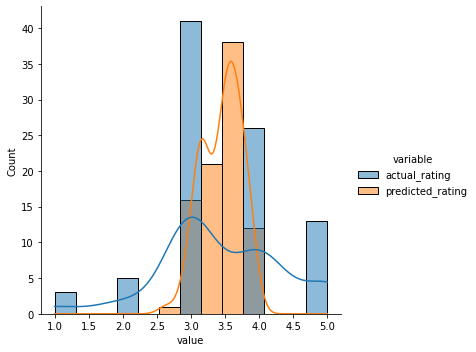

In [63]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

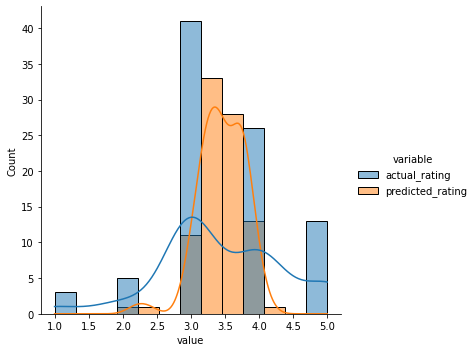

In [64]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [65]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### Computing the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values

In [66]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [67]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user,similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item,algo_svd,svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.767
-----> Recall:  0.41
> k=5, model=KNNBasic
-----> Precision:  0.776
-----> Recall:  0.421
> k=5, model=KNNBasic
-----> Precision:  0.676
-----> Recall:  0.353
> k=5, model=KNNBasic
-----> Precision:  0.677
-----> Recall:  0.351
> k=5, model=SVD
-----> Precision:  0.75
-----> Recall:  0.386
> k=5, model=SVD
-----> Precision:  0.745
-----> Recall:  0.381
> k=10, model=KNNBasic
-----> Precision:  0.748
-----> Recall:  0.55
> k=10, model=KNNBasic
-----> Precision:  0.752
-----> Recall:  0.561
> k=10, model=KNNBasic
-----> Precision:  0.657
-----> Recall:  0.502
> k=10, model=KNNBasic
-----> Precision:  0.657
-----> Recall:  0.503
> k=10, model=SVD
-----> Precision:  0.73
-----> Recall:  0.514
> k=10, model=SVD
-----> Precision:  0.735
-----> Recall:  0.526


In [68]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [20,30,40]

# Make list of models
models = [algo_svd,svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=20, model=SVD
-----> Precision:  0.723
-----> Recall:  0.623
> k=20, model=SVD
-----> Precision:  0.719
-----> Recall:  0.624
> k=30, model=SVD
-----> Precision:  0.716
-----> Recall:  0.659
> k=30, model=SVD
-----> Precision:  0.712
-----> Recall:  0.665
> k=40, model=SVD
-----> Precision:  0.715
-----> Recall:  0.676
> k=40, model=SVD
-----> Precision:  0.708
-----> Recall:  0.682


### Comparing the results from the base line user-user and item-item based models.


**Write your Answer here:**<br>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax"></th>
    <th class="tg-0lax">User-User</th>
    <th class="tg-0lax">User-User tuned</th>
    <th class="tg-0lax">Item-Item</th>
    <th class="tg-0lax">Item-Item tuned</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">RMSE</td>
    <td class="tg-baqh">0.9925</td>
    <td class="tg-baqh">0.9571</td>
    <td class="tg-baqh">0.9433</td>
    <td class="tg-baqh">0.9352</td>
  </tr>
  <tr>
    <td class="tg-0lax">Prediction <br>user 4<br>movie 10</td>
    <td class="tg-baqh">3.62</td>
    <td class="tg-baqh">3.74</td>
    <td class="tg-baqh">4.26</td>
    <td class="tg-baqh">4.43</td>
  </tr>
  <tr>
    <td class="tg-0lax">Prediction <br>user 4<br>movie 3</td>
    <td class="tg-baqh">3.20</td>
    <td class="tg-baqh">3.72</td>
    <td class="tg-baqh">3.87</td>
    <td class="tg-baqh">4.00</td>
  </tr>
  <tr>
    <td class="tg-0lax">k=5<br>precision<br>recall<br>F1-score</td>
    <td class="tg-baqh">0.767<br>0.413<br>0.537</td>
    <td class="tg-baqh">0.772<br>0.420<br>0.544<br></td>
    <td class="tg-baqh">0.676<br>0.353<br>0.464<br></td>
    <td class="tg-baqh">0.683<br>0.355<br>0.467</td>
  </tr>
  <tr>
    <td class="tg-0lax">k=10<br>precision<br>recall<br>F1-score</td>
    <td class="tg-baqh">0.749<br>0.547<br>0.632<br></td>
    <td class="tg-baqh">0.760<br>0.565<br>0.648</td>
    <td class="tg-baqh">0.660<br>0.505<br>0.572<br></td>
    <td class="tg-baqh">0.659<br>0.504<br>0.571</td>
  </tr>
</tbody>
</table>

- The lowest value of RMSE is that of the item-item hyperparameter-tuned based collaborative filter baseline model.
- The closest value of prediction for the already rated movie are the user-user tuned and item-item, with a difference of -0.24 and 0.24 correspondingly.
- The highest values of precision and recall, for k=5 and k=10, are those of the user-user and user-user tuned models.
- All things consider, the F1-scores of the user-user and user-user tuned models for k=10 are the greatest. The recall is somewhat low, which means that there will be a great deal of false negatives (around 45%), which is to say that there will be movies which are relevant for the user, but will be not recommended; on the other side, precision value is not so low and therefore there won't be so many false positives i.e. there is a great deal of movies recommended to the user (around 75%) that will be relevant.
- In general, the user-user based collaborative filter baseline model seems to perform better than the item-item based collaborative filter baseline model.

### How do these baseline models compare to each other with respect to the tuned user-user and item-item models?

- The user-user based collaborative filter baseline model where the hyperparameter tuning was carried outperform the item-item based collaborative filter baseline model in predictions, and in precission and recall.
- However, the item-item tuned model has a lower RMSE.

### Comparing the RMSE and precision recall for the models.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax"></th>
    <th class="tg-baqh">User-User</th>
    <th class="tg-baqh">User-User <br>tuned</th>
    <th class="tg-baqh">Item-Item</th>
    <th class="tg-baqh">Item-Item <br>tuned</th>
    <th class="tg-baqh">Matrix factorization</th>
    <th class="tg-baqh">Matrix factorization<br>tuned<br></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">RMSE</td>
    <td class="tg-baqh">0.9925</td>
    <td class="tg-baqh">0.9571</td>
    <td class="tg-baqh">0.9433</td>
    <td class="tg-baqh">0.9352</td>
    <td class="tg-baqh">0.9054</td>
    <td class="tg-baqh">0.8950</td>
  </tr>
  <tr>
    <td class="tg-0lax">Prediction <br>user 4<br>movie 10</td>
    <td class="tg-baqh">3.62</td>
    <td class="tg-baqh">3.74</td>
    <td class="tg-baqh">4.26</td>
    <td class="tg-baqh">4.43</td>
    <td class="tg-baqh">3.91</td>
    <td class="tg-baqh">3.99</td>
  </tr>
  <tr>
    <td class="tg-0lax">Prediction <br>user 4<br>movie 3</td>
    <td class="tg-baqh">3.20</td>
    <td class="tg-baqh">3.72</td>
    <td class="tg-baqh">3.87</td>
    <td class="tg-baqh">4.00</td>
    <td class="tg-baqh">3.78</td>
    <td class="tg-baqh">3.65</td>
  </tr>
  <tr>
    <td class="tg-0lax">k=5<br>precision<br>recall<br>F1-score</td>
    <td class="tg-baqh">0.767<br>0.413<br>0.537</td>
    <td class="tg-baqh">0.772<br>0.420<br>0.544<br></td>
    <td class="tg-baqh">0.676<br>0.353<br>0.464<br></td>
    <td class="tg-baqh">0.683<br>0.355<br>0.467</td>
    <td class="tg-baqh">0.751<br>0.382<br>0.506</td>
    <td class="tg-baqh">0.751<br>0.388<br>0.512</td>
  </tr>
  <tr>
    <td class="tg-0lax">k=10<br>precision<br>recall<br>F1-score</td>
    <td class="tg-baqh">0.749<br>0.547<br>0.632<br></td>
    <td class="tg-baqh">0.760<br>0.565<br>0.648</td>
    <td class="tg-baqh">0.660<br>0.505<br>0.572<br></td>
    <td class="tg-baqh">0.659<br>0.504<br>0.571</td>
    <td class="tg-baqh">0.731<br>0.515<br>0.604</td>
    <td class="tg-baqh">0.731<br>0.523<br>0.610<br></td>
  </tr>
</tbody>
</table>

-  The matrix factorization uses the data of that same user in order to predict the relationship between other items and other users of a specific 'type', it uses latent features to make a prediction based on both item and user entities.
- It uses Singular Value Decomposition to factorize the matrix and obtains a diagonal matrix containing the singular values of the original matrix, which represents how important a specific feature is to predict user preferences.<br>

- The RMSE of the Matrix factorization model is lower than both user-user CF and item-item CF, making the closes approximation to that known value; however, in the case of prediction and recall, user-user CF seems to perform somehow better than the matrix factorization model.


- The matrix factorization model could be overfitting the data. 
- Maybe the content (description of the movie, genre, etc) of the items is not adequate in order to use this kind of filter alone.
- As the value of k becomes larger, the recall seems to improve and the prediction of more relevant movies will increase, the downside is that precision will decrease as a trade off. 
- The Matrix factorization tuned model improves the recall, while the precision remains the same as the model that wasn't tuned.

### **Conclusions**

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.